In [1]:
"""Volume 2: Non-negative Matrix Factorization."""

import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
import os
from imageio import imread
import warnings
from itertools import product
warnings.filterwarnings("ignore")

from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error as mse

In [2]:
#Problems 1-2
class NMFRecommender:

    def __init__(self,random_state=15,rank=3,maxiter=200,tol=1e-3):
        """The parameter values for the algorithm"""
        #Intialize objects
        self.random_state = random_state
        self.rank = rank
        self.maxiter = maxiter
        self.tol = tol
        
    
    def initialize_matrices(self,m,n):
        """randomly initialize the W and H matrices,"""
        #Initialize the matrices
        np.random.seed(self.random_state)
        self.W = np.random.random((m, self.rank))
        self.H = np.random.random((self.rank, n))
        return self.W, self.H

      
    def fit(self,V):
        """Fits W and H weight matrices using CVXPY"""
        #Fits W and H weight metracies
        C_W = cp.Variable(self.W.shape, nonneg=True)
        C_H = cp.Variable(self.H.shape, nonneg=True)
        C_W.value = self.W
        C_H.value = self.H
        itr = 0

        while itr < self.maxiter:

            #Find optimal W
            obj_W = cp.Minimize(cp.norm(V - C_W @ self.H, 'fro'))
            prob_W = cp.Problem(obj_W)
            prob_W.solve()

            #Find optimal H
            obj_H = cp.Minimize(cp.norm(V - C_W.value @ C_H, 'fro'))
            prob_H = cp.Problem(obj_H)
            prob_H.solve()

            #End Case
            if np.linalg.norm(C_W.value - self.W, 'fro') < self.tol and np.linalg.norm(C_H.value - self.H, 'fro') < self.tol:
                break

            self.W = C_W.value
            self.H = C_H.value
            itr += 1

        


    def reconstruct(self):
        """Reconstruct V matrix for comparison against the original V"""
        #Reconstruct matrix V
        return self.W @ self.H


In [3]:
def prob3():
    """Run NMF recommender on the grocery store example"""
    V = np.array(
        [
            [0, 1, 0, 1, 2, 2],
            [2, 3, 1, 1 ,2, 2],
            [1, 1, 1, 0, 1, 1],
            [0, 2, 3, 4, 1, 1],
            [0, 0, 0, 0, 1, 0]
        ]
    )
    #Creates Grocery Store Object
    groc = NMFRecommender(rank=2)
    groc.initialize_matrices(*V.shape)
    #Runs NMF on V
    groc.fit(V)
    return groc.W, groc.H, sum(groc.H[0] < groc.H[1])

In [4]:
prob3()

(array([[4.32435328e-01, 1.55966416e+00],
        [7.29134779e-01, 2.67333067e+00],
        [2.59681622e-01, 1.23203923e+00],
        [2.77123823e+00, 7.23996896e-08],
        [1.92952002e-09, 3.68942540e-01]]),
 array([[9.14789740e-08, 7.26347516e-01, 1.07598515e+00, 1.44658120e+00,
         3.52992321e-01, 3.65556964e-01],
        [5.85644297e-01, 7.72134844e-01, 6.57075361e-02, 8.93992985e-09,
         8.03673962e-01, 7.67537884e-01]]),
 4)

In [5]:

#get data
def get_faces(path="./faces94"):
    """Traverse the specified directory to obtain one image per subdirectory.
    Flatten and convert each image to grayscale.

    Parameters:
        path (str): The directory containing the dataset of images.

    Returns:
        ((mn,k) ndarray) An array containing one column vector per
            subdirectory. k is the number of people, and each original
            image is mxn.
    """
    # Traverse the directory and get one image per subdirectory.
    faces = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                # Load the image, convert it to grayscale,
                # and flatten it into a vector.
                faces.append(np.ravel(imread(dirpath+"/"+fname, as_gray=True)))
                break
    # Put all the face vectors column-wise into a matrix.
    return np.transpose(faces)

def show(image, m=200, n=180, plt_show=False):
    """Plot the flattened grayscale 'image' of width 'w' and height 'h'.

    Parameters:
        image ((mn,) ndarray): A flattened image.
        m (int): The original number of rows in the image.
        n (int): The original number of columns in the image.
        plt_show (bool): if True, call plt.show() at the end
    """
    #scale image
    image = image / 255
    #reshape image
    image = np.reshape(image,(m,n))
    #show image
    plt.imshow(image,cmap = "gray")
    
    if plt_show:
        plt.show()


In [6]:
def prob4():
    """
        Gridsearch over rank, alpha and l1_ratio values to reconstruct 
        image using NMF. Plot all reconstructed images.
    """
    faces = get_faces()
    norm = []
    prod = product([0, 0.2, 0.5], [0, 1e-5, 1])
    itr = 1
    for alpha, ratio in prod:
        model = NMF(n_components=75, alpha=alpha, l1_ratio=ratio)
        W = model.fit_transform(faces)
        H = model.components_
        norm.append(np.linalg.norm(faces[:,2] - W @ H[:,2]))
        plt.subplot(3,3,itr)
        plt.title(f'alpha={alpha}, ratio={ratio}')
        show(W @ H[:,2])
        itr += 1
    plt.tight_layout()
    plt.show()
    return np.argmin(norm)


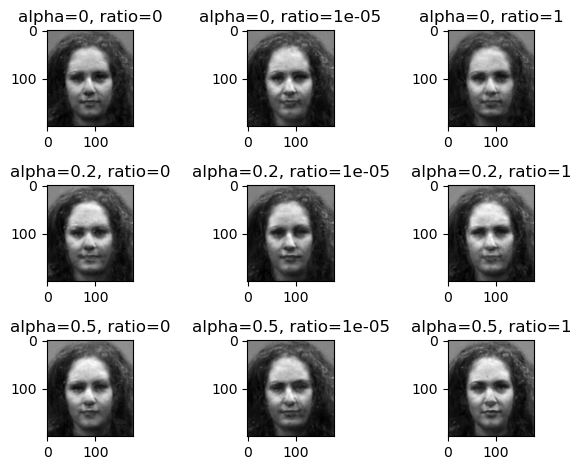

8

In [7]:
prob4()

The best combiniation of parameters was (75, 0, 0)

In [8]:
def prob5():
    '''
        find the 10 basis faces with the largest coefficients 
        corresponding to the the second and twelfth face in the dataset. 
        Plot these basis faces along with the original image using 
        subplots
    '''
    faces = get_faces()
    model = NMF(n_components=75, alpha=0, l1_ratio=0)
    W = model.fit_transform(faces)
    H = model.components_
    return W, H

In [9]:
W, H = prob5()

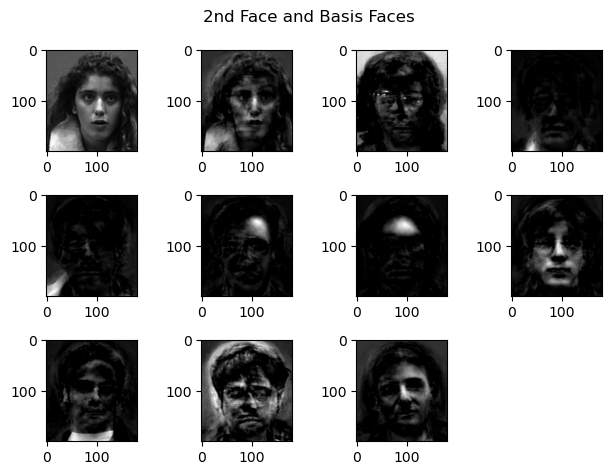

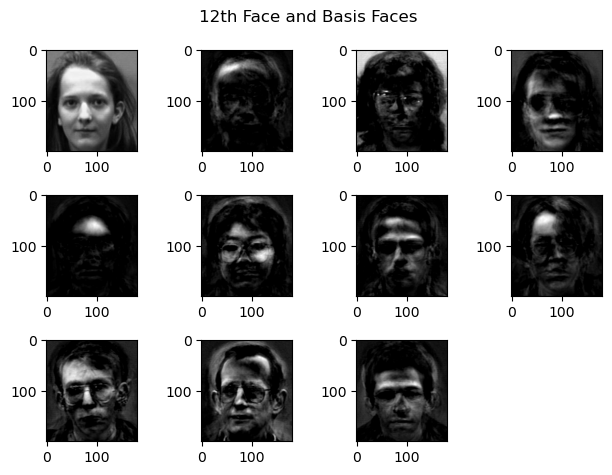

In [11]:
faces = get_faces()
#10 Coefficients of the 2nd image
sort_2 = np.argsort(H[:,1])[::-1][:10]
#10 Coefficients of the 12th image
sort_12 = np.argsort(H[:,11])[::-1][:10]

#Original 2nd Face
plt.subplot(341)
show(faces[:,1])

#Basis Faces corresponding to the 2nd Face
for itr, i in enumerate(sort_2):
    plt.subplot(3,4,itr+2)
    show(W[:,i])
    
plt.suptitle('2nd Face and Basis Faces')
plt.tight_layout()
plt.show()

#Original 12th Face
plt.subplot(341)
show(faces[:,11])

#Basis Face corresponding to the 12th Face
for itr, i in enumerate(sort_12):
    plt.subplot(3, 4, itr+2)
    show(W[:,i])
    
plt.suptitle('12th Face and Basis Faces')
plt.tight_layout()
plt.show()